# Projeto german credit risk

In [84]:
import requests
import logging
import zipfile
import pandas as pd

from pathlib import Path

In [85]:
DATA_DIR = Path.cwd().parent / 'data'

In [86]:
def load_data(data_dir: Path):
    pickle_file_path = data_dir / 'data.pkl'
    if not pickle_file_path.exists():
        data_dir.mkdir(parents=True, exist_ok=True)

        url = 'https://archive.ics.uci.edu/static/public/144/statlog+german+credit+data.zip'
        response = requests.get(url)
        if response.status_code != 200:
            logging.info('Failed to download dataset.')
            return None

        file_path = data_dir / 'data.zip'
        with open(file_path, 'wb') as file:
            file.write(response.content)
        logging.info('Dataset downloaded successfully.')

        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(path=data_dir)

        columns = [
            'status',
            'duration',
            'history',
            'purpose',
            'amount',
            'savings',
            'employment',
            'installment',
            'status_sex',
            'guarantors',
            'residence',
            'property_type',
            'age',
            'plans',
            'housing',
            'credits',
            'job',
            'dependents',
            'telephone',
            'foreign',
            'target',
        ]
        data = pd.read_csv(
            data_dir / 'german.data',
            sep=' ', 
            header=None, 
            names=columns,
        )

        data.to_pickle(pickle_file_path)
    else:
        data = pd.read_pickle(pickle_file_path)

    return data

In [87]:
data = load_data(DATA_DIR)

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   status         1000 non-null   object
 1   duration       1000 non-null   int64 
 2   history        1000 non-null   object
 3   purpose        1000 non-null   object
 4   amount         1000 non-null   int64 
 5   savings        1000 non-null   object
 6   employment     1000 non-null   object
 7   installment    1000 non-null   int64 
 8   status_sex     1000 non-null   object
 9   guarantors     1000 non-null   object
 10  residence      1000 non-null   int64 
 11  property_type  1000 non-null   object
 12  age            1000 non-null   int64 
 13  plans          1000 non-null   object
 14  housing        1000 non-null   object
 15  credits        1000 non-null   int64 
 16  job            1000 non-null   object
 17  dependents     1000 non-null   int64 
 18  telephone      1000 non-null 

In [89]:
y = data["target"]-1
y.value_counts()
data = data.drop(columns=["target"])


In [90]:
data

,status,duration,history,purpose,amount,savings,employment,installment,status_sex,guarantors,residence,property_type,age,plans,housing,credits,job,dependents,telephone,foreign
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,4,A121,31,A143,A152,1,A172,1,A191,A201
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,4,A122,40,A143,A152,1,A174,1,A192,A201
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,4,A123,38,A143,A152,1,A173,1,A191,A201
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,4,A124,23,A143,A153,1,A173,1,A192,A201


In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42,stratify=y)

In [92]:
cat_cols = []
num_cols = []
for col in data.columns:
    if data[col].dtype == "object":
        cat_cols.append(col)
    elif col != "target":
        num_cols.append(col)

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

original_cols = data.columns
pipeline = ColumnTransformer([
    ('num',StandardScaler(),num_cols),
    ('cat',OneHotEncoder(),cat_cols)
])

X_train_prep = pipeline.fit_transform(X_train)
X_test_prep = pipeline.fit_transform(X_test)



In [94]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_prep, y_train)

LogisticRegression()

In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_test_pred = log_reg.predict(X_test_prep)

print('Accuracy: {}'.format(accuracy_score(y_test, Y_test_pred)))
print('Precision: {}'.format(precision_score(y_test, Y_test_pred, average='macro')))
print('Recall: {}'.format(recall_score(y_test, Y_test_pred, average='macro')))
print('F1: {}'.format(f1_score(y_test, Y_test_pred, average='macro')))

Accuracy: 0.7818181818181819
Precision: 0.7438095718392255
Recall: 0.7113997113997115
F1: 0.7230640123082661


In [96]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(X_train_prep,y_train)

RandomForestClassifier()

In [97]:
Y_test_pred = forest.predict(X_test_prep)

print('Accuracy: {}'.format(accuracy_score(y_test, Y_test_pred)))
print('Precision: {}'.format(precision_score(y_test, Y_test_pred, average='macro')))
print('Recall: {}'.format(recall_score(y_test, Y_test_pred, average='macro')))
print('F1: {}'.format(f1_score(y_test, Y_test_pred, average='macro')))

Accuracy: 0.7606060606060606
Precision: 0.7279718456725757
Recall: 0.652958152958153
F1: 0.6669434685404024


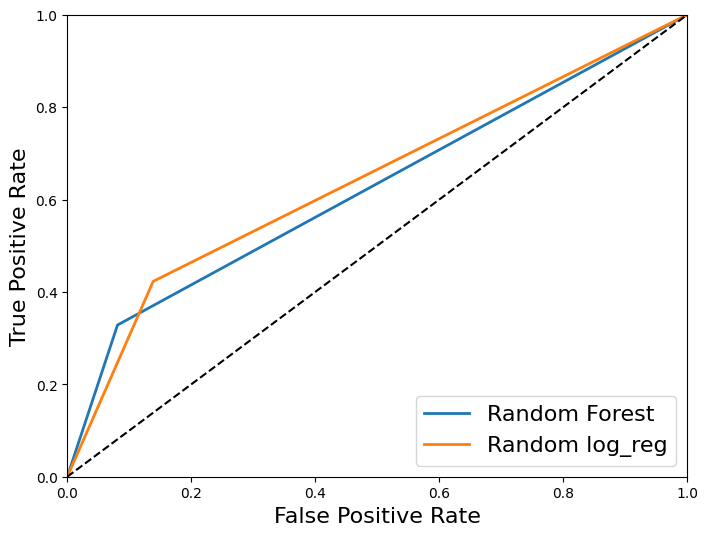

In [98]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

y_scores_log_reg = cross_val_predict(
    log_reg,
    X_train_prep,
    y_train,
    cv=200,
    n_jobs=-1,
)

fpr_log_reg, tpr_log_reg, thresholds_forest = roc_curve(
    y_train,
    y_scores_log_reg,
)


y_scores_forest = cross_val_predict(
    forest,
    X_train_prep,
    y_train,
    cv=200,
    n_jobs=-1,
)

fpr_forest, tpr_forest, thresholds_forest = roc_curve(
    y_train,
    y_scores_forest,
)

plt.figure(figsize=(8, 6))
plt.plot(fpr_forest, tpr_forest, linewidth=2, label="Random Forest")
plt.plot(fpr_log_reg, tpr_log_reg, linewidth=2, label="Random log_reg")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.show()